In [36]:
# 导入常用库
import pandas as pd                      # 数据处理主力军
import numpy as np                       # 数学计算 + 缺失值处理
import matplotlib.pyplot as plt          # 可视化
import seaborn as sns                    # 更美观的可视化

# 设置图表风格
sns.set(style="whitegrid")               # 让图表背景更清爽
plt.rcParams['font.size'] = 12           # 设置默认字体大小
plt.rcParams['figure.figsize'] = (10, 6) # 设置图表默认大小

# 设置 Pandas 显示参数
pd.set_option('display.max_columns', 100)       # 最多显示 100 列（避免列被省略）
pd.set_option('display.max_rows', 100)          # 最多显示 100 行（避免行被省略）
pd.set_option('display.max_colwidth', 200)      # 每列最多显示 200 个字符（防止文本被截断）
pd.set_option('display.float_format', '{:.2f}'.format)  # 浮点数显示为 2 位小数

In [48]:
# 设置支持中文的字体（如微软雅黑、SimHei等）
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


### 识别关键指标

In [49]:
df_key = pd.read_excel('key_action.xlsx')
df_key.head()

key_action  key_action_cnt  retention_rate
0         收藏               1            0.00
1         收藏               2            0.03
2         收藏               3            0.03
3         收藏               4            0.03
4         收藏               5            0.15

In [50]:
df_key['key_action'].unique().tolist()

['收藏', '分享', '更换模板', '消息互动']

In [51]:
collection_cnt = df_key[df_key['key_action'] == '收藏']
share_cnt = df_key[df_key['key_action'] == '分享']
template_cnt = df_key[df_key['key_action'] == '更换模板']
message_cnt = df_key[df_key['key_action'] == '消息互动']

In [52]:
corr1 = collection_cnt[['key_action_cnt','retention_rate']].corr()
print(corr1)

                key_action_cnt  retention_rate
key_action_cnt            1.00            0.81
retention_rate            0.81            1.00


In [53]:
corr2 = share_cnt[['key_action_cnt','retention_rate']].corr()
print(corr2)

                key_action_cnt  retention_rate
key_action_cnt            1.00            0.93
retention_rate            0.93            1.00


In [54]:
corr3 = template_cnt[['key_action_cnt','retention_rate']].corr()
print(corr3)

                key_action_cnt  retention_rate
key_action_cnt            1.00            0.86
retention_rate            0.86            1.00


In [55]:
corr4 = message_cnt[['key_action_cnt','retention_rate']].corr()
print(corr4)

                key_action_cnt  retention_rate
key_action_cnt            1.00            0.54
retention_rate            0.54            1.00


In [56]:
# corr>0.8 与留存率相关性较大的指标：收藏、分享、更换模板
key_action = ['收藏', '分享', '更换模板']

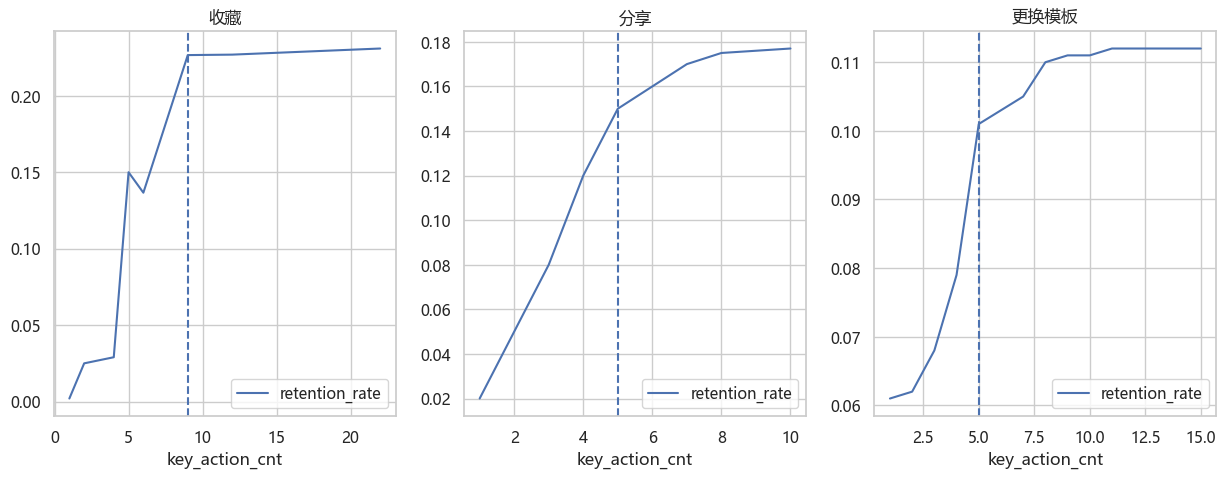

In [59]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i, key in enumerate(key_action):
    df_plot = df_key[df_key['key_action'] == key]
    df_plot.plot(kind='line',x='key_action_cnt',y='retention_rate',ax=ax[i],title=key)

ax[0].axvline(x=9,ls='--')
ax[1].axvline(x=5,ls='--')
ax[2].axvline(x=5,ls='--')

### 确定关键行为标准
收藏数为9，分享数为5，更换模板数为5

## 层次分析法
由于原有资料的权重打分表不确定评判标准，虽然它符合AHP的判断矩阵：  
对角线都是 1  
成对互反关系（A vs B = 2，B vs A = 0.5）  
值分布合理（1/5 到 5 的区间）  
最终执行了一致性检验 CR < 0.1

但是它的使用时长占权重最高，而广告展示次数最具相关性，和真实业务略有差异，并没有考虑到启动次数多、广告也多的情况

所以此处使用数据驱动+回归分析确定相关性矩阵

### ❌原权重打分表分析

In [139]:
df_score = pd.read_excel('权重打分表.xlsx',index_col='Z')
df_score

launch_cnt   PV  ad_show_cnt  duration
Z                                                  
launch_cnt            1 0.50         0.33      0.20
PV                    2 1.00         0.50      0.25
ad_show_cnt           3 2.00         1.00      0.33
duration              5 4.00         3.00      1.00

In [ ]:
# 特征向量法得出权重
# def函数直接ai出，只需要知道这个方法能科学求出权重就行）
def eigenvector_ahp(matrix):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_idx = np.argmax(eigenvalues)
    weights = eigenvectors[:, max_idx].real
    weights = weights / weights.sum()  # 归一化
    return weights

weights = eigenvector_ahp(df_score)
print("特征向量法权重:", weights)

特征向量法权重: [0.08375196 0.13772546 0.23229999 0.54622259]
